In [15]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# Truncate the data so it's feasible to train on local machine

df = pd.read_csv('weatherHistory.csv').iloc[0:20000]
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2008-02-19 03:00:00.000 +0100,Mostly Cloudy,rain,2.333333,0.411111,0.59,6.7298,279.0,15.8263,0.0,1024.55,Mostly cloudy starting overnight continuing un...
19996,2008-02-19 04:00:00.000 +0100,Mostly Cloudy,rain,2.916667,-0.194444,0.61,11.7369,278.0,14.9569,0.0,1023.92,Mostly cloudy starting overnight continuing un...
19997,2008-02-19 05:00:00.000 +0100,Mostly Cloudy,rain,2.794444,-0.233333,0.67,11.2056,290.0,11.2056,0.0,1023.78,Mostly cloudy starting overnight continuing un...
19998,2008-02-19 06:00:00.000 +0100,Mostly Cloudy,rain,2.822222,-1.300000,0.67,17.4041,289.0,11.2056,0.0,1023.85,Mostly cloudy starting overnight continuing un...


In [17]:
# Only consider numerical columns of the dataframe

X = df[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
        'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 
        'Loud Cover', 'Pressure (millibars)']].to_numpy()

In [18]:
# Scale the data into a range from 0-1

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [19]:
# Manually batch data into 32 day batches for training,
# then split the batches into a training and testing split.

batch_size = 32

X_batches = []
y_batches = []

# An X_batch is all the numerical columns for a 31 day period
# A y_batch is the temperature for the 32nd day
for i in range(len(X) - batch_size):
    X_batches.append(X[i:i+batch_size])
    y_batches.append(X[i+batch_size, 0])

train_X, test_X, train_y, test_y = train_test_split(
    np.array(X_batches), np.array(y_batches),
    test_size=0.2, shuffle=False
)

In [21]:
class RNN_Model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(RNN_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, dtype=torch.float64)
        self.output = nn.Linear(hidden_dim, output_dim, dtype=torch.float64)
    def forward(self, x):
        out, h_0 = self.rnn(x)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [22]:
def train(train_X, train_y, model, epochs=10, lr = 0.001):
    """Train RNN Model

    Args:
        train_X (torch.tensor): training input data
        train_y (torch.tensor): training output data
        model (RNN_Model): _Recurrent neural network (PyTorch)
        epochs (int, optional): Number of epochs to train for. Defaults to 10.
        lr (float, optional): Learning rate. Defaults to 0.001.

    Returns:
        list: loss over each epoch
    """
    loss_func = torch.nn.MSELoss()
    optimizer =torch.optim.Adam(model.parameters(), lr=lr)
    loss_list = []
    for epoch in range(epochs):
        model.train()
        print("Epoch: " + str(epoch))

        output = model(train_X)
        loss = loss_func(output, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")
        loss_list.append(loss.item())
        
    return loss_list


In [23]:
rnn = RNN_Model(input_dim=8,output_dim=1,hidden_dim=16,n_layers=1)

In [24]:
loss_history = train(
    torch.tensor(train_X, dtype=torch.float64),
    torch.tensor(train_y.reshape(-1,1), dtype=torch.float64),
    rnn, epochs=50, lr=.01
)

Epoch: 0


Loss: 0.5147555111882883
Epoch: 1
Loss: 0.21138712109337043
Epoch: 2
Loss: 0.07702104615014682
Epoch: 3
Loss: 0.03858855221161469
Epoch: 4
Loss: 0.054132163609196766
Epoch: 5
Loss: 0.0743437401393994
Epoch: 6
Loss: 0.07440237319830025
Epoch: 7
Loss: 0.06035719160559687
Epoch: 8
Loss: 0.044064174008442814
Epoch: 9
Loss: 0.0328559808607471
Epoch: 10
Loss: 0.028881766402380098
Epoch: 11
Loss: 0.03065522332672709
Epoch: 12
Loss: 0.03460651040923191
Epoch: 13
Loss: 0.03710822045322512
Epoch: 14
Loss: 0.0364765216585648
Epoch: 15
Loss: 0.03321946728113545
Epoch: 16
Loss: 0.028964060636189174
Epoch: 17
Loss: 0.02533990919390738
Epoch: 18
Loss: 0.023325521005563732
Epoch: 19
Loss: 0.02303849929804021
Epoch: 20
Loss: 0.02386115996419365
Epoch: 21
Loss: 0.02482572017437494
Epoch: 22
Loss: 0.025099029784339606
Epoch: 23
Loss: 0.024322740582881603
Epoch: 24
Loss: 0.022671161756033942
Epoch: 25
Loss: 0.02067450961918237
Epoch: 26
Loss: 0.018939148409516278
Epoch: 27
Loss: 0.017884112595553274
Epoch

In [29]:
import matplotlib.pyplot as plt

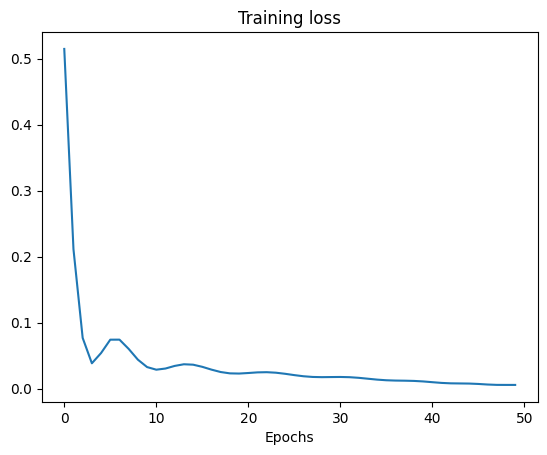

In [30]:
plt.plot(range(50), loss_history)
plt.title("Training loss")
plt.xlabel("Epochs")
plt.show()

In [31]:
plot_len = 500
predict = rnn(torch.tensor(test_X, dtype=torch.float64))
x_vals = np.linspace(0, plot_len, plot_len)

In [58]:
# Implementing a manual rescaler since the data was scaled before
# y was split off. Specific to dataset, since the 0th index is
# temperature, which is what we are interested for y

def rescale(scaler, data):
    return (data - scaler.min_[0]) / scaler.scale_[0]

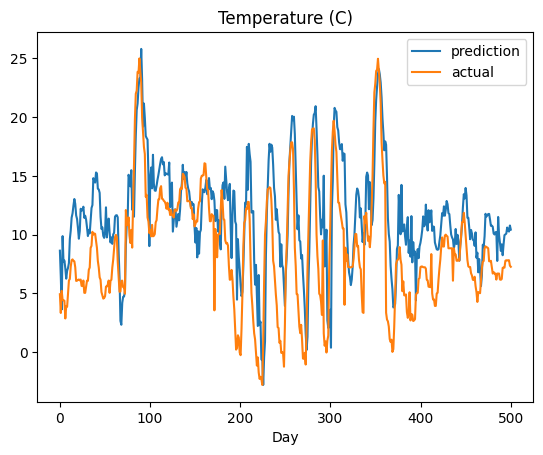

In [57]:
plt.plot(x_vals, rescale(scaler, predict.detach()[:plot_len]), label='prediction')
plt.plot(x_vals, rescale(scaler, test_y[:plot_len]), label='actual')
plt.title("Temperature (C)")
plt.xlabel("Day")
plt.legend()
plt.show()